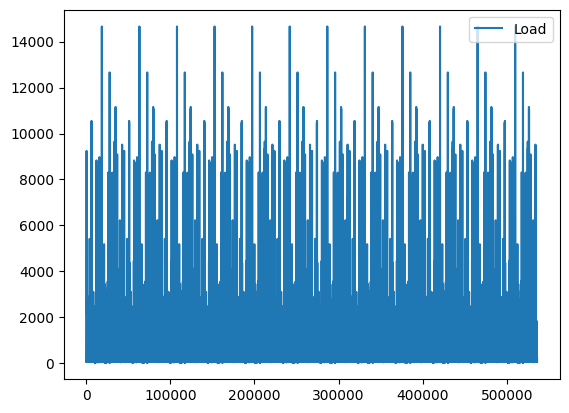

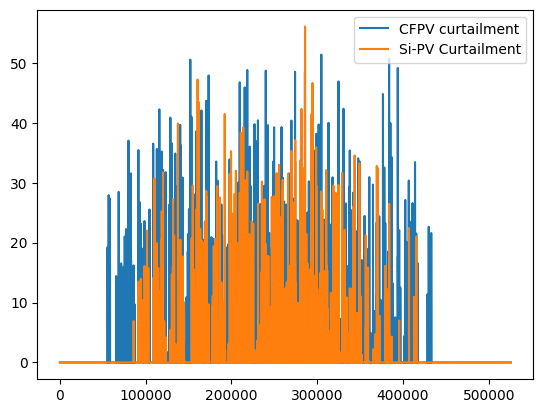

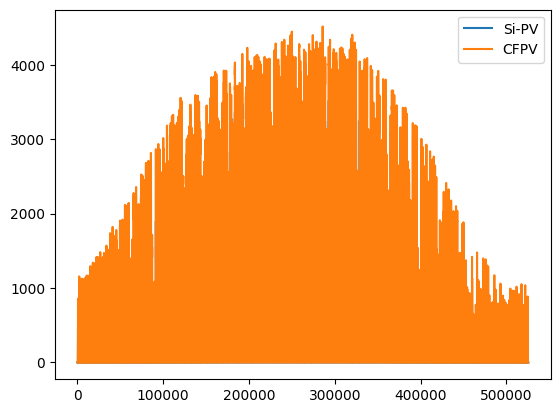

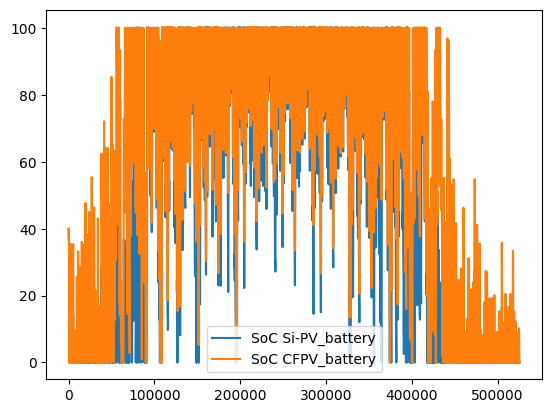

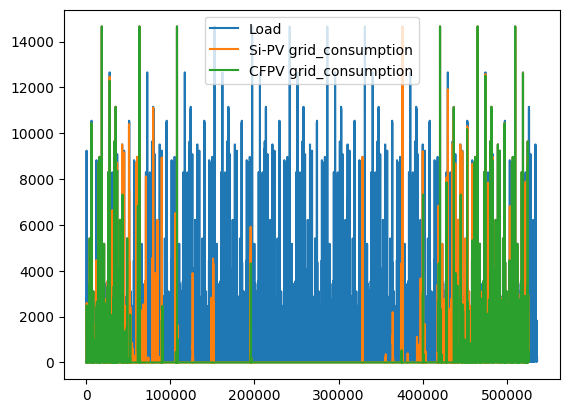

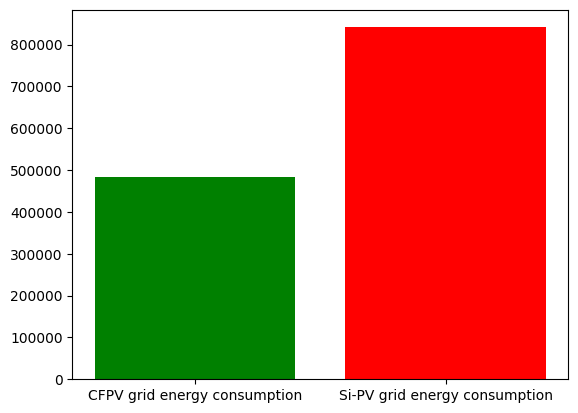

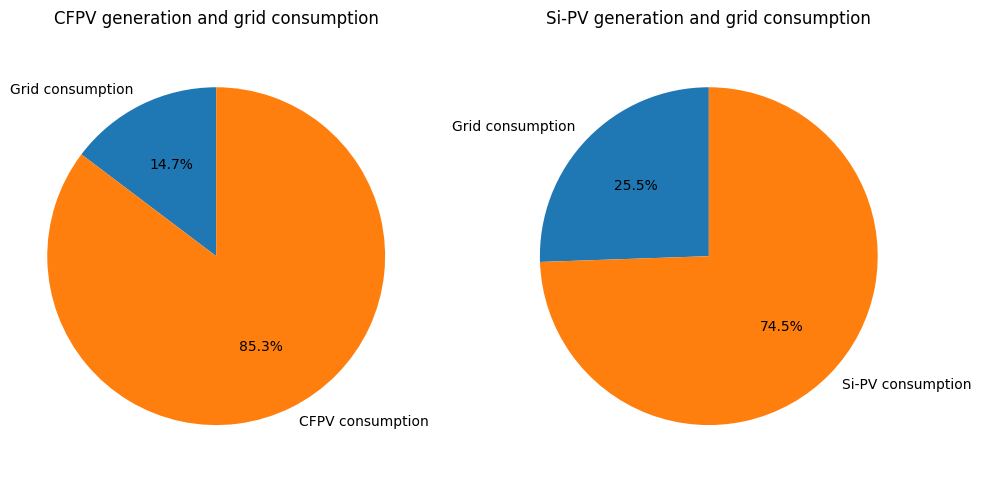

In [1]:
######## This is how this script will determine both cases ######
# 1. Renewable Energy Source Alone (Without Battery):
# Self-Consumption (%) = (Energy Consumed On-Site / Total Energy Generated) * 100
# 2. Renewable Energy Source with Battery Storage:
# Energy Stored in Battery = Energy Generated - Energy Consumed On-Site (when generation exceeds consumption)
# Energy Discharged from Battery = Energy Consumed On-Site - Energy Generated (when consumption exceeds generation)
# Total Energy Generated = Sum of Energy Consumed On-Site + Energy Stored in Battery (when generation exceeds consumption)
# Self-Consumption (%) = (Energy Consumed On-Site + Energy Discharged from Battery) / Total Energy Generated) * 100

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import builtins

date_period = '2022-01-01/2023-01-01'

self_consumption_file = '/Users/alexisaglar/decentralised_network_analysis/data/plots/self_consumption_july.png'
battery_capacity = 10000
SoC_battery = 40

file_path = glob.glob('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/load_profiles/*.csv')
year_combined_load_profile = pd.concat((pd.read_csv(f, sep=',') for f in file_path), ignore_index=True)
year_combined_load_profile = pd.DataFrame(year_combined_load_profile)
year_combined_load_profile['mult'] = year_combined_load_profile['mult']*1000

def plot_graph(df, label, file_name):
    for i in range(len(df)):
        plt.plot(df[i], label=label[i])
    plt.legend()
    # plt.savefig(f'data/plots/{file_name}.png')
    plt.show()

with builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Load_profile_1.csv', newline='') as loadprofile_file, open('/Users/alexisaglar/decentralised_network_analysis/data/pv_generation_data/pv_profiles/profile_year.csv', newline='') as pvprofile_file:
    pv_profile = pd.read_csv(pvprofile_file)
    range_days = date_period.split('/')
    mask = (pv_profile['index_date'] >= range_days[0]) & (pv_profile['index_date'] <= range_days[1])
    pv_profile = pv_profile[mask]
    
    load_profile = pd.read_csv(loadprofile_file)
    load_profile['mult'] = load_profile['mult']*1000

#repeat_factor = len(pv_profile)/len(year_combined_load_profile)+1
repeat_factor = 12
year_combined_load_profile =  pd.concat([year_combined_load_profile] * repeat_factor, ignore_index=True)


#CFPV 
grid_consumption_cfpv = pd.DataFrame(np.zeros(525599), columns=['consumption'])
battery_energy_cfpv = pd.DataFrame(np.zeros(525599), columns=['energy'])
curtailment_cfpv = pd.DataFrame(np.zeros(525599), columns=['curtailment'])
battery_energy_cfpv['energy'][0] = battery_capacity*(SoC_battery/100)

#for i, _ in year_combined_load_profile.iterrows():
for i in range(525599):
    cfpv_generated = pv_profile['P_CFPV'][i]/60
    consumption = year_combined_load_profile['mult'].iloc[i]/60
    
    if consumption > cfpv_generated:
        energy_demand_battery = (consumption - cfpv_generated)

        if battery_energy_cfpv['energy'][i] > energy_demand_battery:
            battery_energy_cfpv['energy'][i+1] = battery_energy_cfpv['energy'][i] - energy_demand_battery

        else:
            grid_consumption_cfpv['consumption'][i] = energy_demand_battery - battery_energy_cfpv['energy'][i]
            battery_energy_cfpv['energy'][i+1] = 0

    else:
        if battery_energy_cfpv['energy'][i] < battery_capacity:
            battery_energy_cfpv['energy'][i+1] = battery_energy_cfpv['energy'][i] + (cfpv_generated-consumption)
        if battery_energy_cfpv['energy'][i] >= battery_capacity:
            curtailment_cfpv['curtailment'][i] = battery_energy_cfpv['energy'][i] - battery_capacity 
            battery_energy_cfpv['energy'][i+1] = battery_capacity
    
#Silicon 
battery_energy_p = pd.DataFrame(np.zeros(525599), columns=['energy'])
grid_consumption_p = pd.DataFrame(np.zeros(525599), columns=['consumption'])
curtailment_p = pd.DataFrame(np.zeros(525599), columns=['curtailment'])
battery_energy_p['energy'][0] = battery_capacity*(SoC_battery/100)

#for i, _ in year_combined_load_profile.iterrows():
for i in range(525599):
    p_generated = pv_profile['P'][i]/60
    consumption = year_combined_load_profile['mult'][i]/60
    if consumption > p_generated:
        energy_demand_battery = (consumption - p_generated)

        if battery_energy_p['energy'][i] >= energy_demand_battery:
            battery_energy_p['energy'][i+1] = battery_energy_p['energy'][i] - energy_demand_battery

        else:
            grid_consumption_p['consumption'][i] = energy_demand_battery - battery_energy_p['energy'][i]
            battery_energy_p['energy'][i+1] = 0

    else:
        if battery_energy_p['energy'][i] < battery_capacity:
            battery_energy_p['energy'][i+1] = battery_energy_p['energy'][i] + (p_generated-consumption)
        if battery_energy_p['energy'][i] >= battery_capacity:
            curtailment_p['curtailment'][i] = battery_energy_p['energy'][i] - battery_capacity 
            battery_energy_p['energy'][i+1] = battery_capacity

plot_graph([year_combined_load_profile['mult']], ['Load'], 'combined_load')
plot_graph([curtailment_cfpv['curtailment'],curtailment_p['curtailment']], ['CFPV curtailment','Si-PV Curtailment'], 'curtailment_year')
plot_graph([pv_profile['P'], pv_profile['P_CFPV']], ['Si-PV','CFPV'], 'PV_generation_year')
plot_graph([battery_energy_p/100, battery_energy_cfpv/100], ['SoC Si-PV_battery', 'SoC CFPV_battery'], 'state_of_charge_year')
plot_graph([year_combined_load_profile['mult'], grid_consumption_p*60, grid_consumption_cfpv*60], ['Load', 'Si-PV grid_consumption', 'CFPV grid_consumption'], 'grid_energy_consumption_year')

total_cfpv = grid_consumption_cfpv.sum()[0]
total_p = grid_consumption_p.sum()[0]
plt.bar(['CFPV grid energy consumption', 'Si-PV grid energy consumption'], [total_cfpv, total_p], color=['green', 'red'])
plt.show()

sizes_cfpv = [grid_consumption_cfpv.sum()[0]/(year_combined_load_profile['mult'].sum()/60) * 100, ((year_combined_load_profile['mult'].sum()/60) - grid_consumption_cfpv.sum()[0])/ (year_combined_load_profile['mult'].sum()/60) *100]
labels_cfpv = ['Grid consumption','CFPV consumption']
sizes_p= [grid_consumption_p.sum()[0]/(year_combined_load_profile['mult'].sum()/60) * 100, ((year_combined_load_profile['mult'].sum()/60) - grid_consumption_p.sum()[0])/ (year_combined_load_profile['mult'].sum()/60) *100]
labels_p = ['Grid consumption','Si-PV consumption']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(sizes_cfpv, labels=labels_cfpv, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('CFPV generation and grid consumption')
ax2.pie(sizes_p, labels=labels_p, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Si-PV generation and grid consumption')
plt.tight_layout()
# plt.savefig('data/plots/pie_charts_year.png')
plt.show()

#date_range = pd.date_range(start='2022-01-01', end='2023-01-01', freq='T')
#date_range = date_range.drop(date_range[-2])
#x['time'] = date_range
#x['time'] = pd.to_datetime(x['time'])
#x.set_index('time', inplace=True)
#plt.plot(x.groupby(x.index.strftime('%H:%M')).mean())


#plt.plot(range(1,54), pv_profile['P'].groupby(pv_profile.index.strftime('%Y-%U')).max(), label='Si-PV_max', color='red', linestyle='--')

#plt.bar(range(1,54), grid_consumption_cfpv['consumption'].groupby(grid_consumption_cfpv.index.strftime('%Y-%U')).sum()*60, width=0.35, label='CFPV grid consumption', color='blue', alpha=0.5)
#plt.bar([week + 0.35 for week in range(1,54)], grid_consumption_p['consumption'].groupby(grid_consumption_p.index.strftime('%Y-%U')).sum()*60, width=0.35, label='Si-PV grid consumption', color='red', alpha=0.5)

In [2]:
date_range = pd.date_range(start='2022-01-01', end='2023-01-01', freq='T')
date_range = date_range.drop(date_range[-1])
pv_profile['time'] = date_range
pv_profile.set_index('time', inplace=True)


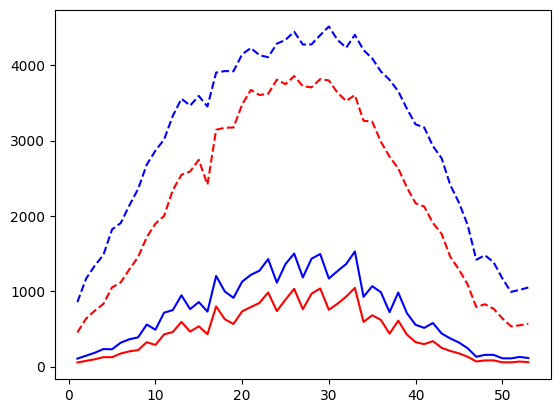

In [3]:
power_CFPV_max= pv_profile['P_CFPV'].groupby(pv_profile.index.strftime('%Y-%U')).max()
# power_CFPV_max = power_CFPV_max.drop(power_CFPV_max.index[-1])
power_si_max = pv_profile['P'].groupby(pv_profile.index.strftime('%Y-%U')).max()
# power_si_max = power_si_max.drop(power_si_max.index[-1])
power_CFPV_mean = pv_profile['P_CFPV'].groupby(pv_profile.index.strftime('%Y-%U')).mean()
# power_CFPV_mean = power_CFPV_mean.drop(power_CFPV_mean.index[-1])
power_si_mean = pv_profile['P'].groupby(pv_profile.index.strftime('%Y-%U')).mean()
# power_si_mean = power_si_mean.drop(power_si_mean.index[-1])

fig, ax1 = plt.subplots()
ax1.plot(range(1,54), power_CFPV_max, label='CFPV_max', color='blue', linestyle='--')
ax1.plot(range(1,54), power_si_max, label='Si-PV_max', color='red', linestyle='--')
ax1.plot(range(1,54), power_CFPV_mean, label='CFPV_mean', color='blue', linestyle='-')
ax1.plot(range(1,54), power_si_mean, label='Si-PV_mean', color='red', linestyle='-')

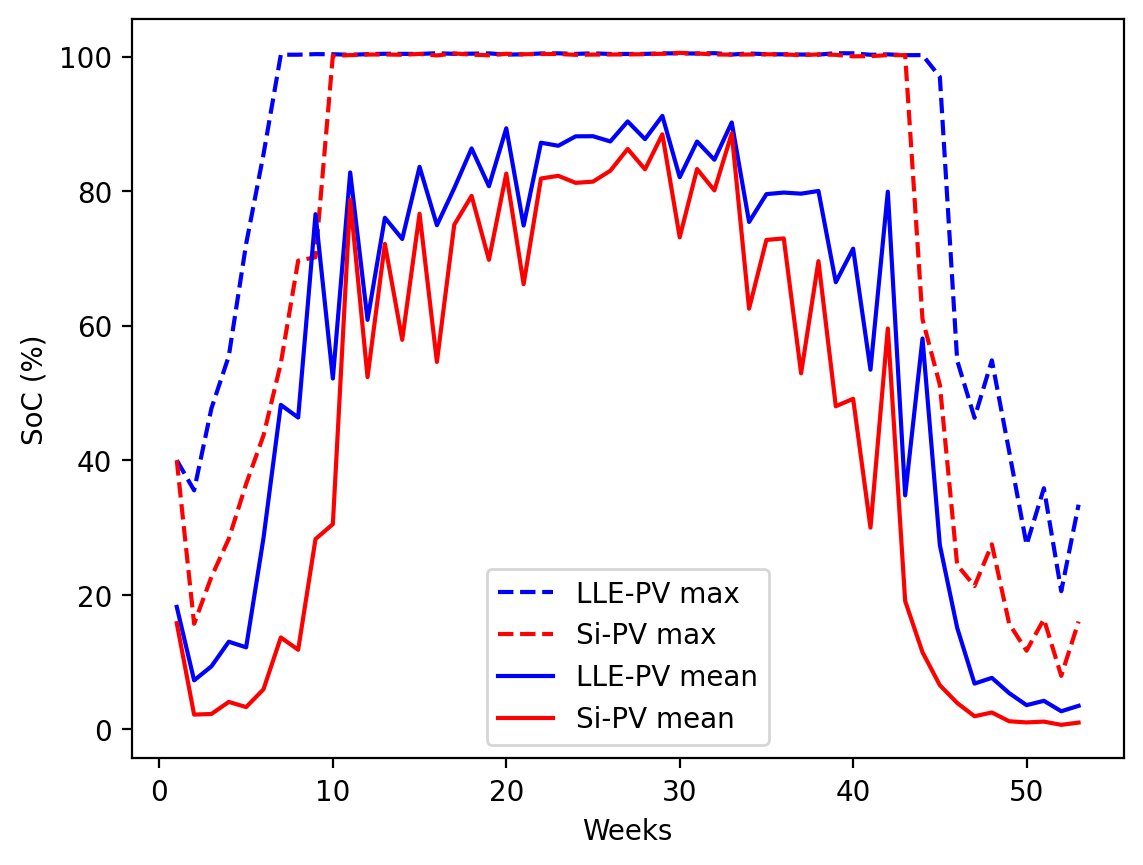

In [4]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)

battery_energy_p.set_index(date_range[:-1], inplace=True)
battery_energy_cfpv.set_index(date_range[:-1], inplace=True)
battery_p_max = battery_energy_p.groupby(battery_energy_p.index.strftime('%Y-%U')).max()/100
battery_p_mean = battery_energy_p.groupby(battery_energy_p.index.strftime('%Y-%U')).mean()/100
battery_cfpv_max= battery_energy_cfpv.groupby(battery_energy_cfpv.index.strftime('%Y-%U')).max()/100
battery_cfpv_mean= battery_energy_cfpv.groupby(battery_energy_cfpv.index.strftime('%Y-%U')).mean()/100


fig, ax1 = plt.subplots()
ax1.plot(range(1,54), battery_cfpv_max, label='LLE-PV max', color='blue', linestyle='--')
ax1.plot(range(1,54), battery_p_max, label='Si-PV max', color='red', linestyle='--')
ax1.plot(range(1,54), battery_cfpv_mean, label='LLE-PV mean', color='blue', linestyle='-')
ax1.plot(range(1,54), battery_p_mean, label='Si-PV mean', color='red', linestyle='-')


ax1.set_ylabel('SoC (%)')
ax1.set_xlabel('Weeks')
ax1.legend()

# # Add legends for both plots
ax1.legend(loc='lower center')

In [5]:
pv_profile

,index_date,P,P_CFPV
time,,,
2022-01-01 00:00:00,2022-01-01 00:00:00,-0.0,-0.0
2022-01-01 00:01:00,2022-01-01 00:01:00,0.0,0.0
2022-01-01 00:02:00,2022-01-01 00:02:00,0.0,0.0
2022-01-01 00:03:00,2022-01-01 00:03:00,0.0,0.0
2022-01-01 00:04:00,2022-01-01 00:04:00,0.0,0.0
...,...,...,...
2022-12-31 23:55:00,2022-12-31 23:55:00,0.0,0.0
2022-12-31 23:56:00,2022-12-31 23:56:00,0.0,0.0
2022-12-31 23:57:00,2022-12-31 23:57:00,0.0,0.0


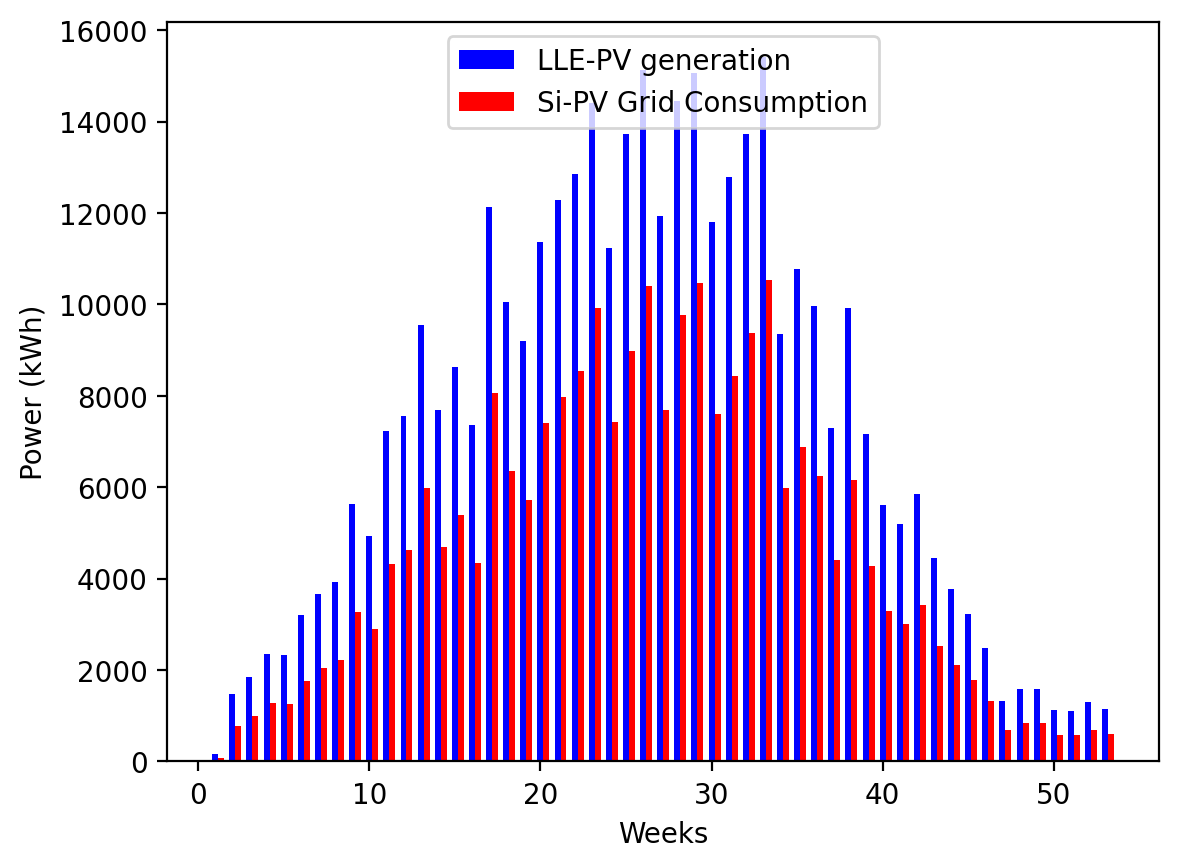

In [6]:
plt.bar(range(1,54), pv_profile['P_CFPV'].groupby(pv_profile.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='LLE-PV generation', color='blue')
plt.bar([week + 0.35 for week in range(1,54)], pv_profile['P'].groupby(pv_profile.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='Si-PV Grid Consumption', color='red')

plt.ylabel('Power (kWh)')
plt.xlabel('Weeks')
plt.legend(loc='upper center')

# # Add legends for both plots
plt.show()

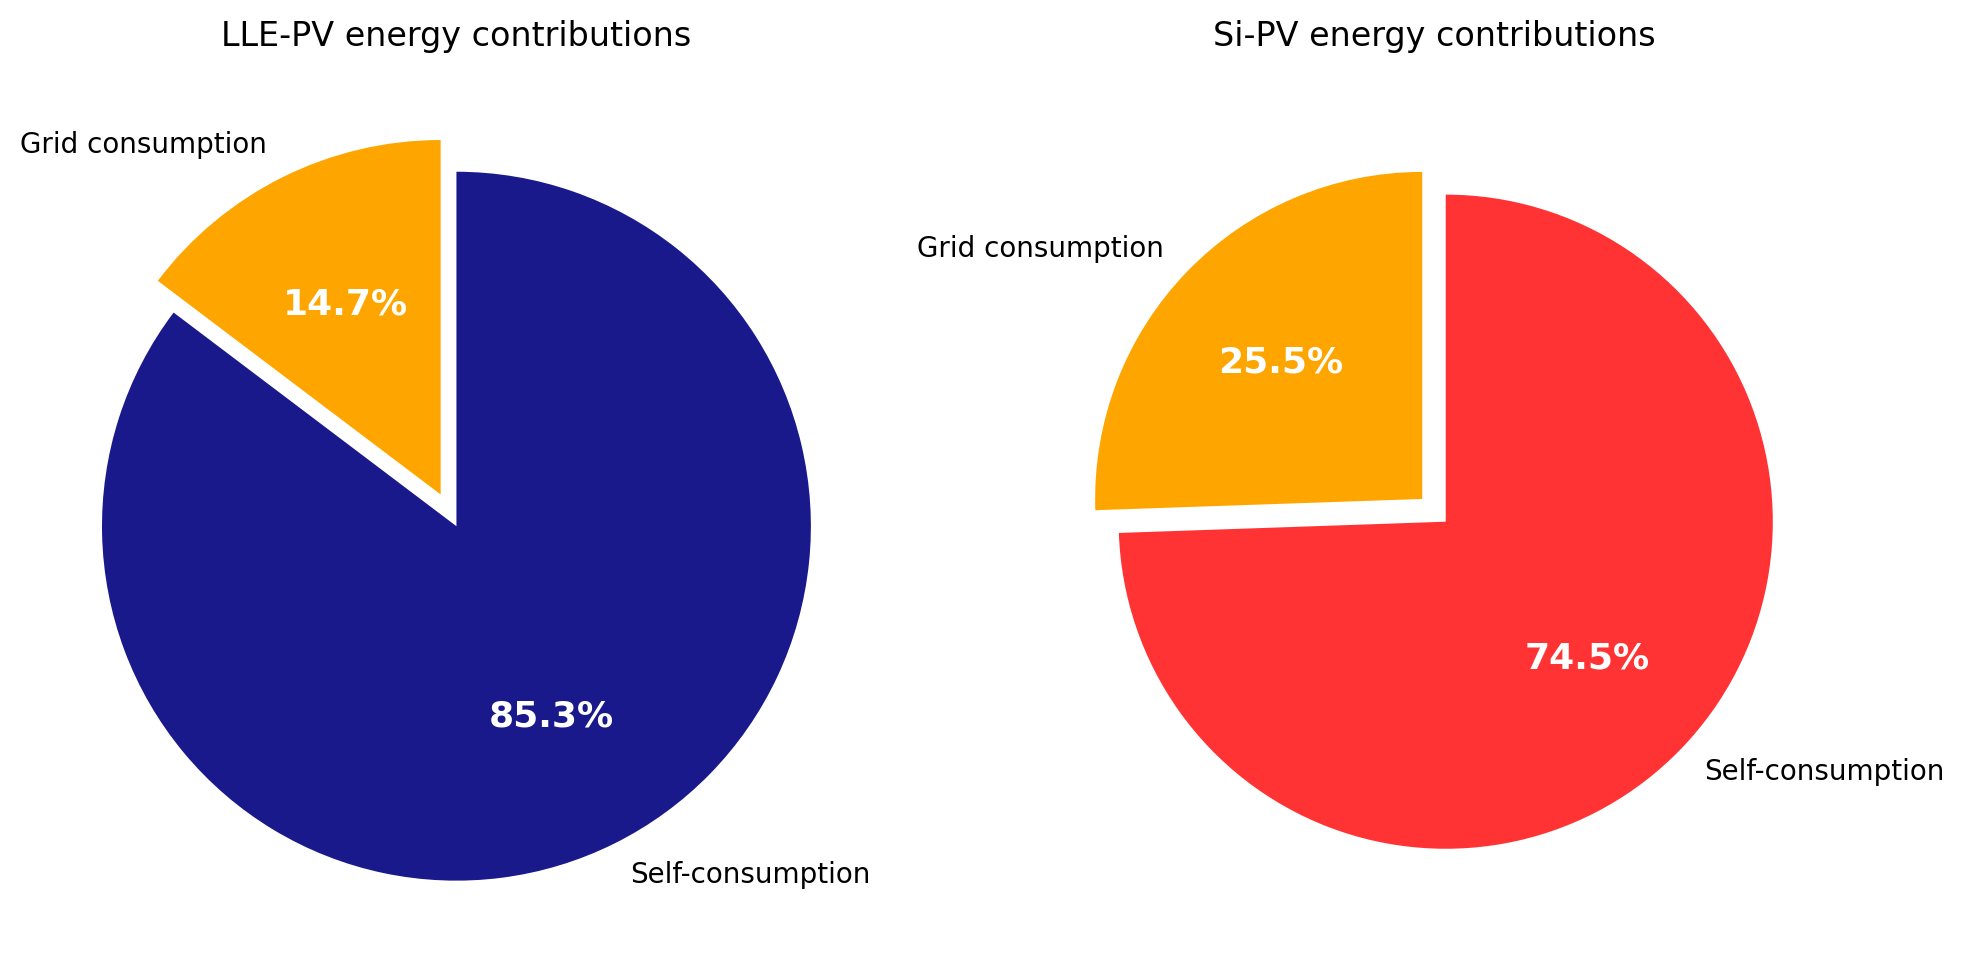

In [7]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)

sizes_cfpv = [grid_consumption_cfpv.sum()[0]/(year_combined_load_profile['mult'].sum()/60) * 100, ((year_combined_load_profile['mult'].sum()/60) - grid_consumption_cfpv.sum()[0])/ (year_combined_load_profile['mult'].sum()/60) *100]
labels_cfpv = ['Grid consumption','Self-consumption']
sizes_p= [grid_consumption_p.sum()[0]/(year_combined_load_profile['mult'].sum()/60) * 100, ((year_combined_load_profile['mult'].sum()/60) - grid_consumption_p.sum()[0])/ (year_combined_load_profile['mult'].sum()/60) *100]
labels_p = ['Grid consumption','Self-consumption']


# Define the colors you want for each segment
colors = ['#ff9999', '#66b3ff']

# Define the explode parameter to emphasize a segment (e.g., Grid consumption)
explode = (0.1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
wedges1, texts1, autotexts1 = ax1.pie(sizes_cfpv, labels=labels_cfpv, autopct='%1.1f%%', startangle=90, colors=['Orange','#000080E6'], explode=explode)
ax1.axis('equal')
ax1.set_title('LLE-PV energy contributions')

wedges2, texts2, autotexts2 = ax2.pie(sizes_p, labels=labels_p, autopct='%1.1f%%', startangle=90, colors=['orange','#FF0000CC'], explode=explode)
ax2.axis('equal')
ax2.set_title('Si-PV energy contributions')

for autotext in autotexts1 + autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
    
plt.tight_layout()
# plt.savefig('data/plots/pie_charts_year.png')
plt.show()

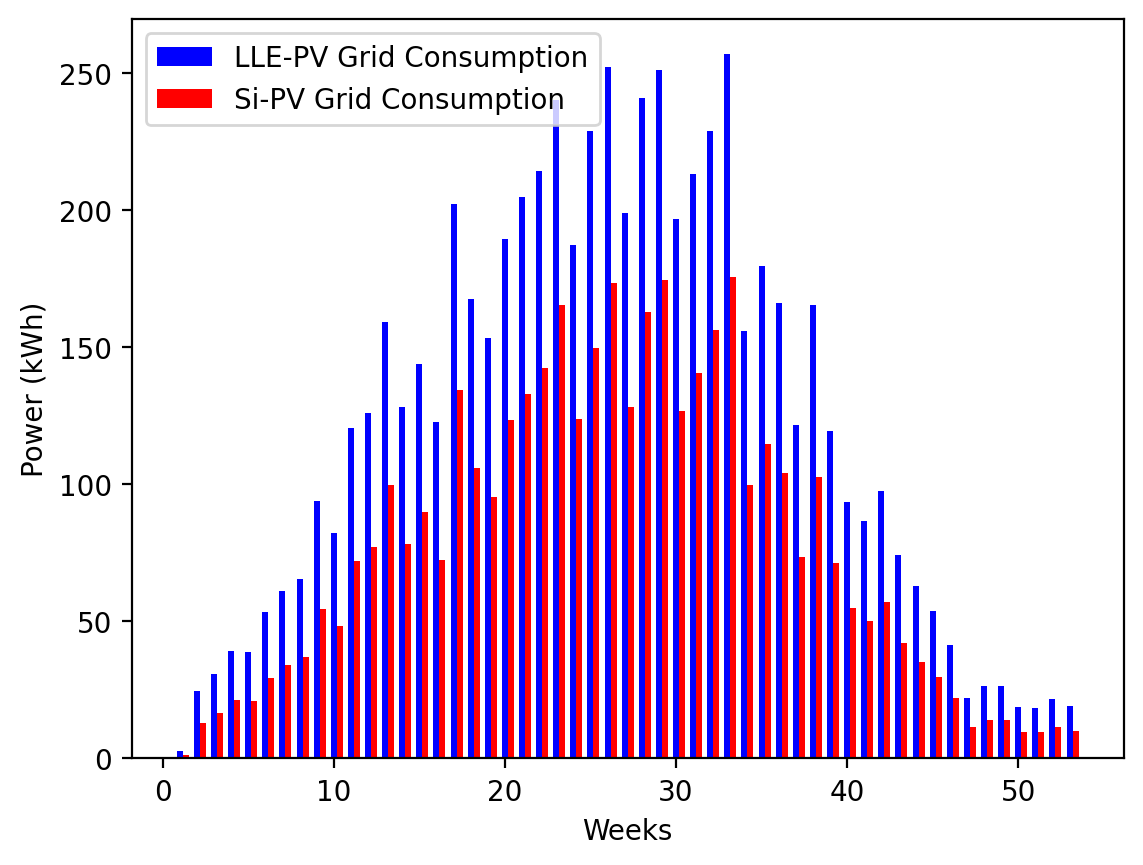

In [8]:
plt.bar(range(1,54), pv_profile['P_CFPV'].groupby(pv_profile.index.strftime('%Y-%U')).sum()/60000, width=0.35, label='LLE-PV Grid Consumption', color='blue')
plt.bar([week + 0.35 for week in range(1,54)], pv_profile['P'].groupby(pv_profile.index.strftime('%Y-%U')).sum()/60000, width=0.35, label='Si-PV Grid Consumption', color='red')

plt.ylabel('Power (kWh)')
plt.xlabel('Weeks')
plt.legend(loc='upper left')

# # Add legends for both plots
plt.show()

In [16]:
date_range = pd.date_range(start='2022-01-01', end='2023-01-01', freq='T')
date_range = date_range.drop(date_range[-1])
date_range = date_range.drop(date_range[-1])
grid_consumption_cfpv['time'] = date_range
grid_consumption_p['time'] = date_range
grid_consumption_cfpv.set_index('time', inplace=True)
grid_consumption_p.set_index('time', inplace=True)

In [1]:

plt.bar(range(1,54), grid_consumption_cfpv['consumption'].groupby(grid_consumption_cfpv.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='LLE-PV grid consumption', color='blue')
plt.bar([week + 0.35 for week in range(1,54)], grid_consumption_p['consumption'].groupby(grid_consumption_p.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='Si-PV grid consumption', color='red')

plt.ylabel('Energy (kWh)')
plt.xlabel('Weeks')
plt.legend(loc='upper center')

# # Add legends for both plots
plt.show()

NameError: name 'plt' is not defined

In [11]:

plt.bar(range(1,54), grid_consumption_cfpv['consumption'].groupby(grid_consumption_cfpv.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='LLE-PV grid consumption', color='blue')
plt.bar([week + 0.35 for week in range(1,54)], grid_consumption_p['consumption'].groupby(grid_consumption_p.index.strftime('%Y-%U')).sum()/1000, width=0.35, label='Si-PV grid consumption', color='red')

plt.ylabel('Power (kWh)')
plt.xlabel('Weeks')
plt.legend(loc='upper center')

# # Add legends for both plots
plt.show()

AttributeError: 'RangeIndex' object has no attribute 'strftime'

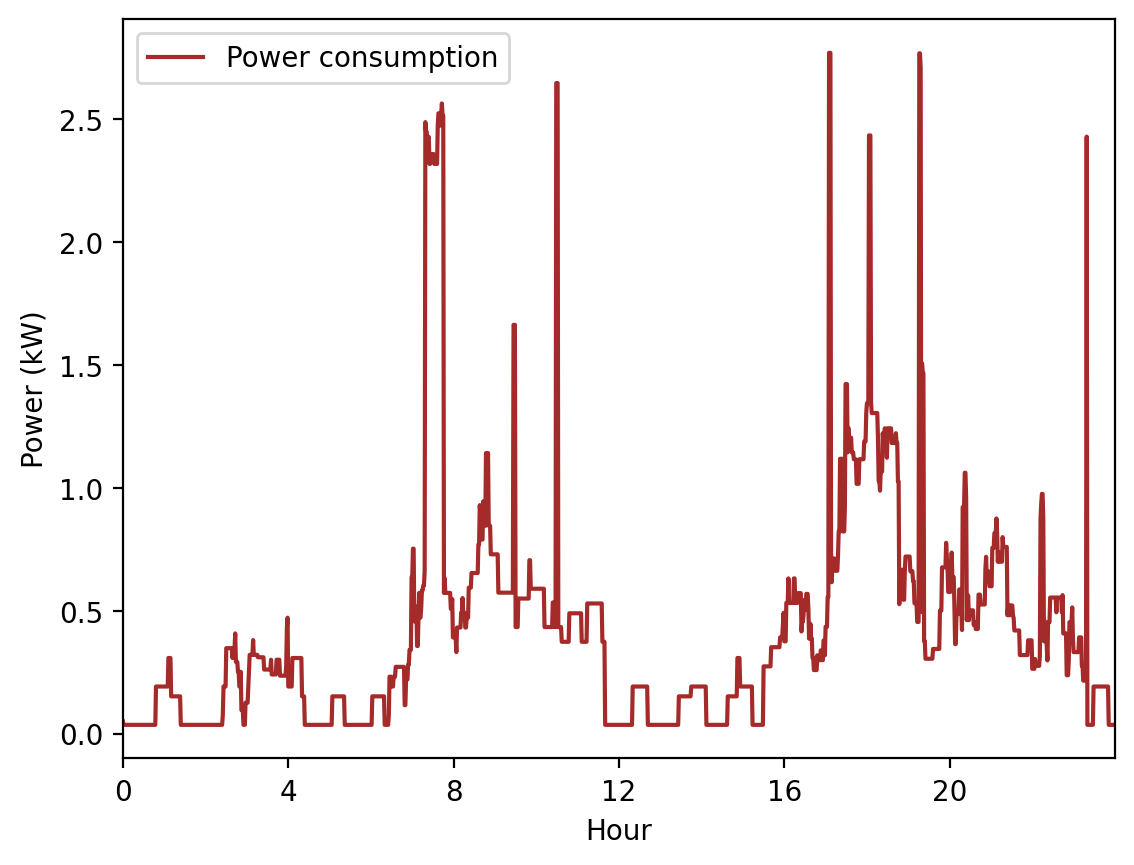

In [ ]:
%config InlineBackend.figure_format = 'retina'  # This sets a higher DPI (e.g., for high-resolution displays)
# date_range = pd.date_range(start='2022-01-01', end='2022-01-02', freq='T')
# date_range = date_range.drop(date_range[-1])
# load_profile['time'] = date_range
# load_profile.set_index('time', inplace=True)
with builtins.open('/Users/alexisaglar/decentralised_network_analysis/data/network_data/network/Load_profile_1.csv', newline='') as loadprofile_file:
    load_profile = pd.read_csv(loadprofile_file)

# Set the x-axis ticks to display only the hours

# fig, ax1 = plt.subplots()
plt.plot(load_profile.index/60, load_profile['mult'], label='Power consumption', color='brown', linestyle='-')
plt.xlim(0, 24)

# hours = np.arange(0, 24)
# tick_positions = [load_profile.index[load_profile.index.hour == h][0] for h in hours]
# tick_labels = [str(h) for h in hours]
x_ticks = np.arange(0, 24, 4)  # Adjust the step value (2 in this case) as needed
plt.xticks(x_ticks)

# ax1.set_xticks(load_profile.index, load_profile.index.strftime('%H'), rotation=45)
plt.ylabel('Power (kW)')
plt.xlabel('Hour')
plt.legend()
# # Add legends for both plots
plt.legend(loc='upper left')
